<a href="https://colab.research.google.com/github/moch1996/Vaycold/blob/main/Python_DL/%EC%97%AC%EB%9F%AC%20%EC%9D%98%EC%83%81%20%EC%82%AC%EC%A7%84%EC%97%90%EC%84%9C%20%EC%98%B7%20%EC%A2%85%EB%A5%98%20%EA%B5%AC%EB%B6%84%ED%95%98%EA%B8%B0~2%EC%B0%A8%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이번 학습의 방향
    1차 모델링결과 메모리 문제로 코랩에서 더 진행할 수가 없기에 
    데이터크기를 줄인 후 다시 모델링을 해보려고 한다.
    데이터의 크기는 절반으로 줄일 예정이다
     train : (30000,28,28)
     test : (5000,28,28)

## Library

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, MaxPool2D, Conv2D, Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image
from google.colab import drive

warnings.filterwarnings('ignore')

SEED=34

In [2]:
# 딱히 필요는 없는 듯 하다..
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

## 지난 번 생성했던 함수들

In [3]:
def idx2label(idx) :
  return labels[idx]

In [4]:
# 이미지 한장의 크기를 4배로 확대하고, 객체는 4분면 영역중 랜덤으로 1공간에 넣는 함수를 작성해보자

def expand(img) :
  bg = np.zeros(img.shape)
  # 1 0
  # 2 3
  idx = np.random.randint(0,4)
  slots = [bg,bg,bg,bg]
  slots[idx] = img
  expanded = np.vstack([
                        np.hstack(slots[:2]), 
                        np.hstack(slots[2:])
                        
  ]
  )
  return expanded

In [5]:
def expand_4times(x_data,y_data) :
  images = []
  labels = []

  for _ in range(4) :
    bg = np.zeros((28,28))
    obj_count = np.random.randint(0,5)

    label = np.zeros((10,))
    slots = [bg, bg,bg,bg]

    for idx in range(obj_count) :
      i = np.random.randint(len(x_data))
      slots[idx] = x_data[i]
      label += tf.keras.utils.to_categorical(y_data[i],10)
    
    np.random.shuffle(slots)
  
  new_img = np.vstack([
                       np.hstack(slots[:2]),
                       np.hstack(slots[2:])
  ])

  images.append(new_img)
  labels.append((label >=1).astype(np.int))
  return np.array(images), np.array(labels)

In [ ]:
'''
있으면 편리할 거 같지만 필수는 아닐 거 같은...

def final(n) :
  res = model2.predict(test_multi_images[n].reshape((1,56,56,1)) )


  plt.figure(figsize=(8,10))

  plt.subplot(311)
  plt.imshow(test_multi_images[n].reshape((56,56))) # 이미지

  plt.subplot(312)
  plt.bar(np.arange(0,10), test_multi_labels[n], color='black')
  plt.title('correct')

  plt.subplot(313)
  plt.bar(np.arange(0,10), res[0], color='gray')
  plt.ylim(0,1.05)


  plt.show()
  for idx in list(np.argwhere(test_multi_labels[n]==1).reshape(-1)) :
    print('')
    print(idx2label(idx))

'''

"\n있으면 편리할 거 같지만 필수는 아닐 거 같은...\n\ndef final(n) :\n  res = model2.predict(test_multi_images[n].reshape((1,56,56,1)) )\n\n\n  plt.figure(figsize=(8,10))\n\n  plt.subplot(311)\n  plt.imshow(test_multi_images[n].reshape((56,56))) # 이미지\n\n  plt.subplot(312)\n  plt.bar(np.arange(0,10), test_multi_labels[n], color='black')\n  plt.title('correct')\n\n  plt.subplot(313)\n  plt.bar(np.arange(0,10), res[0], color='gray')\n  plt.ylim(0,1.05)\n\n\n  plt.show()\n  for idx in list(np.argwhere(test_multi_labels[n]==1).reshape(-1)) :\n    print('')\n    print(idx2label(idx))\n\n"

In [32]:
# 개수에 따라 연속된 그림을 보여주는 함수를 작성해보자
def filter(obj_count, count=5) :
  labels = train_multi_labels.sum(axis=1)
  ids = np.argwhere( labels == obj_count)[:count,0]

  imgs = train_multi_images[ids][...,0].transpose((1,0,2)).reshape(56,-1)
  plt.imshow(imgs)
  plt.show()

## 진행

In [7]:
# fashion MNIST 데이터를 살펴보자
fashion_mnist = keras.datasets.fashion_mnist
((train_images,train_labels),(test_images, test_labels)) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [8]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [12]:
# 데이터를 절반만 사용하자

train_images = train_images[:30000]
train_labels = train_labels[:30000]

test_images = test_images[:5000]
test_labels = test_labels[:5000]


In [60]:
labels = ["T-shirt/top",   #idx 0
          "Trouser",       #idx 1
          "Pullover",      #idx 2
          "Dress",         #idx 3
          "Coat",          #idx 4
          "Sandal",        #idx 5
          "Shirt",         #idx 6
          "Sneaker",       #idx 7
          "Bag",           #idx 8
          "Ankle_boot"]    #idx 9

In [17]:
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)

In [18]:
train_images = train_images / 255
test_images = test_images / 255

In [22]:
train_expand_images = np.array([expand(img) for img in train_images])
test_expand_images = np.array([expand(img) for img in test_images])

In [23]:
train_expand_images.shape, test_expand_images.shape

((30000, 56, 56), (5000, 56, 56))

In [24]:
train_multi_images, train_multi_labels = list(zip(*[expand_4times(train_images, train_labels) for i in train_images]))
test_multi_images, test_multi_labels = list(zip(*[expand_4times(test_images, test_labels) for i in test_images]))

In [25]:
np.array(train_multi_images).shape # 뭐여 중간에1 이 껴있네

(30000, 1, 56, 56)

In [26]:
np.array(train_multi_images)[...,0, :, :].shape

(30000, 56, 56)

In [27]:
# 이렇게 표시하는게 더 이해하기 쉬움
np.array(train_multi_images)[:,0,:,:].shape

(30000, 56, 56)

In [28]:
np.array(train_multi_labels).shape # 얘도 바꿔주자

(30000, 1, 10)

In [29]:
np.array(train_multi_labels)[:,0,:].shape

(30000, 10)

In [30]:
# 데이터셋을 재정의하자
train_multi_images = np.array(train_multi_images)[:,0,:,:].reshape(-1,56,56,1)
train_multi_labels = np.array(train_multi_labels)[:,0,:]

test_multi_images = np.array(test_multi_images)[:,0,:,:].reshape(-1,56,56,1)
test_multi_labels = np.array(test_multi_labels)[:,0,:]

In [31]:
train_multi_images.shape, test_multi_images.shape

((30000, 56, 56, 1), (5000, 56, 56, 1))

In [33]:
# multi label와 train label 차이
train_labels[0]

9

In [34]:
train_multi_labels[0]

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

## Modeling
 - Transfer Learning
   - 학습을 시킨 후 학습한 내용을 바탕으로 다른 모델을 학습시키는 방법

In [46]:
def single_model() :
  with tf.device('/device:GPU:0'):
    input = Input((56,56,1))
    x = Conv2D(16, 2, padding='same',activation='relu')(input)
    x = MaxPool2D(2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(32, 2, padding='same',activation='relu')(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, 2, padding='same',activation='relu')(x)
    x = MaxPool2D(2)(x)
    
    x = Conv2D(64, 2, padding='same',activation='relu')(x) # 추가
    x = MaxPool2D(2)(x)                                    # 추가

    x = GlobalAveragePooling2D()(x) 
    x = Dense(10, activation = 'softmax')(x)

    return Model(input,x)

In [47]:
model = single_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 16)        80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0   

In [48]:
# 만든 모델에 loss 와 optimizer, metric을 설정하자
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [49]:
# 모델 학습시키자
hist = model.fit(train_expand_images.reshape((-1,56,56,1)),
                  to_categorical(train_labels,10),
                  
                  validation_data = (test_expand_images.reshape((-1,56,56,1)),
                                     to_categorical(test_labels,10))
                  ,epochs=20, verbose=1)

Epoch 1/20
938/938 [==============================] - 5s 4ms/step - loss: 1.5180 - accuracy: 0.4250 - val_loss: 0.8609 - val_accuracy: 0.6942
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.8239 - accuracy: 0.6932 - val_loss: 0.6749 - val_accuracy: 0.7590
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.7058 - accuracy: 0.7379 - val_loss: 0.6225 - val_accuracy: 0.7676
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.6391 - accuracy: 0.7617 - val_loss: 0.5853 - val_accuracy: 0.7888
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.5865 - accuracy: 0.7812 - val_loss: 0.5471 - val_accuracy: 0.8046
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.5617 - accuracy: 0.7871 - val_loss: 0.5090 - val_accuracy: 0.8152
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.5387 - accuracy: 0.8006 - val_loss: 0.5077 - val_accuracy: 0.8270
Epoch 

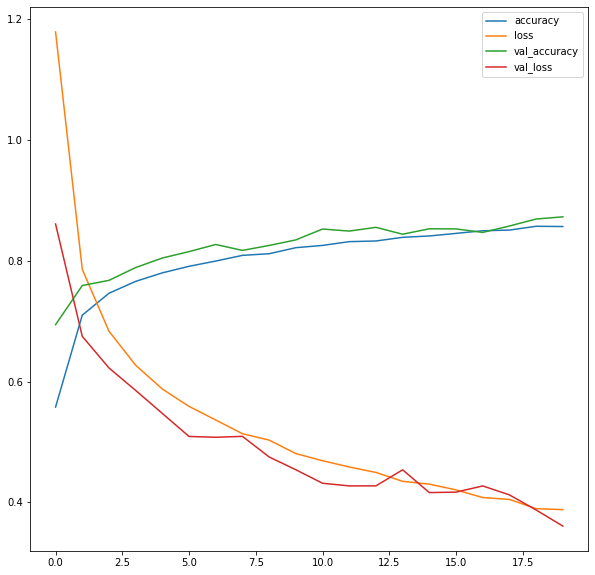

In [50]:
plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

## 결과확인

In [51]:
test_expand_images.shape

(5000, 56, 56)

In [68]:
# 완성된 모델에서 test_expand_image 중 1장을 넣고 결과를 받아보자
res = model.predict(test_expand_images[1].reshape((1,56,56,1)) )
res.shape

(1, 10)

In [69]:
res

array([[1.9034380e-04, 2.3290378e-08, 9.8440474e-01, 5.4743596e-06,
        7.3958505e-03, 7.3328692e-08, 7.9133166e-03, 4.9196363e-09,
        8.2035673e-05, 8.0617965e-06]], dtype=float32)

Pullover


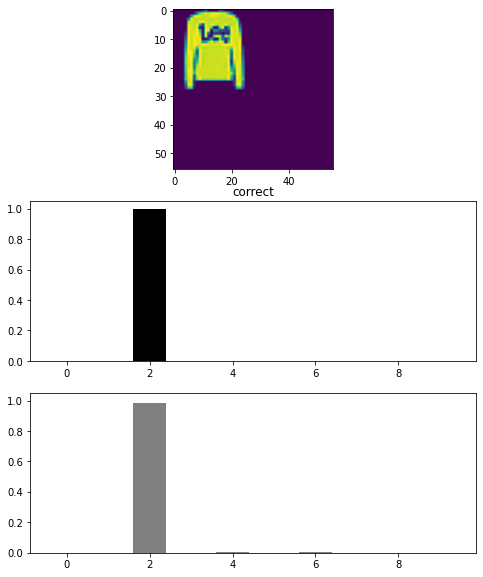

In [70]:
plt.figure(figsize=(8,10))

plt.subplot(311)
plt.imshow(test_expand_images[1])


plt.subplot(312)
plt.bar(np.arange(0,10), to_categorical((test_labels)[1],10), color='black')
plt.title('correct')

plt.subplot(313)
plt.bar(np.arange(0,10), res[0], color='gray')
plt.ylim(0,1.05)
print(idx2label(test_labels[1]))


plt.show()

Pullover


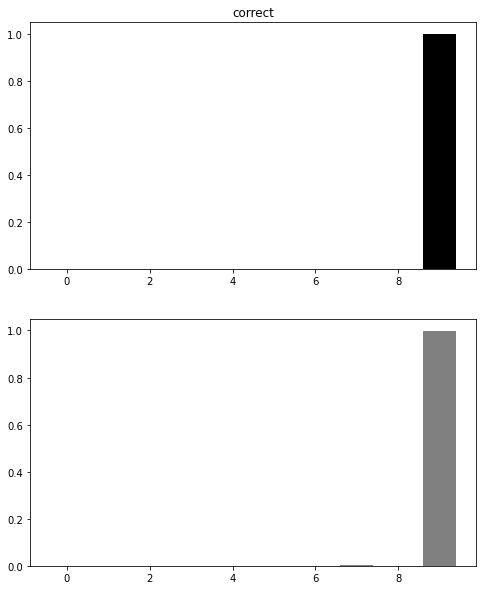

In [72]:
res = model.predict(test_expand_images[1227].reshape((1,56,56,1)) )
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.bar(np.arange(0,10), to_categorical((test_labels)[1227],10), color='black')
plt.title('correct')

plt.subplot(212)
plt.bar(np.arange(0,10), res[0], color='gray')
plt.ylim(0,1.05)
print(idx2label(test_labels[1]))

plt.show()

Ankle_boot


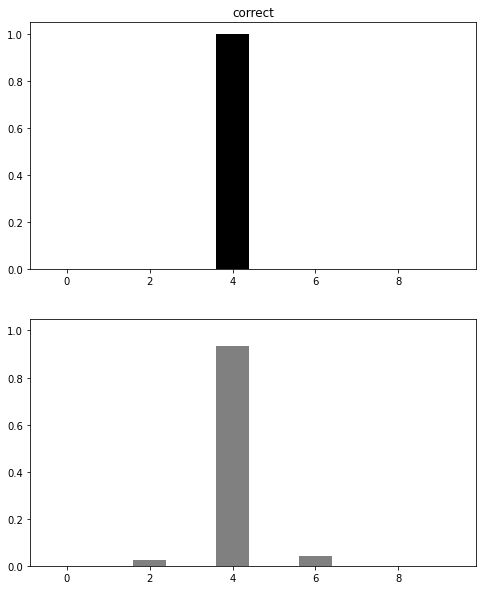

In [73]:
res = model.predict(test_expand_images[426].reshape((1,56,56,1)) )
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.bar(np.arange(0,10), to_categorical((test_labels)[426],10), color='black')
plt.title('correct')

plt.subplot(212)
plt.bar(np.arange(0,10), res[0], color='gray')
plt.ylim(0,1.05)
print(idx2label(test_labels[1227]))

plt.show()

## 멀티 레이블 모델링

In [80]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 16)        80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0   

In [117]:
def multi_model (model) :
  model.trainable = False # 너 모델 학습 잘됐어 수정하지마 라는 의미 역전파 시행하여도 weight 수정이 되지 않음.
  x = model.layers[-2].output
  x = Dense(10, activation='sigmoid')(x)

  return Model(model.input, x)

In [118]:
new_model = multi_model(model)
new_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 16)        80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0   

In [119]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [86]:
# train multi image를 학습해보자

hist2 = new_model.fit(train_multi_images, train_multi_labels,
                      validation_data = (test_multi_images, test_multi_labels),
                      epochs = 20,
                      verbose = 1)

Epoch 1/20
938/938 [==============================] - 4s 3ms/step - loss: 7.4974 - accuracy: 0.1232 - val_loss: 4.8422 - val_accuracy: 0.2124
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 4.9608 - accuracy: 0.2041 - val_loss: 4.3123 - val_accuracy: 0.2790
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 4.6176 - accuracy: 0.2533 - val_loss: 4.1943 - val_accuracy: 0.3082
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 4.4292 - accuracy: 0.2916 - val_loss: 4.0654 - val_accuracy: 0.3144
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 4.3957 - accuracy: 0.3022 - val_loss: 4.0599 - val_accuracy: 0.3390
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 4.3828 - accuracy: 0.3207 - val_loss: 4.0879 - val_accuracy: 0.3428
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 4.4233 - accuracy: 0.3255 - val_loss: 4.1791 - val_accuracy: 0.3414
Epoch 

In [79]:
# 여전히 몹쓸 성능...

In [89]:
def final(n) :
  res = new_model.predict(test_multi_images[n].reshape((1,56,56,1)) )


  plt.figure(figsize=(8,10))

  plt.subplot(311)
  plt.imshow(test_multi_images[n].reshape((56,56))) # 이미지

  plt.subplot(312)
  plt.bar(np.arange(0,10), test_multi_labels[n], color='black')
  plt.title('correct')

  plt.subplot(313)
  plt.bar(np.arange(0,10), res[0], color='gray')
  plt.ylim(0,1.05)


  plt.show()
  for idx in list(np.argwhere(test_multi_labels[n]==1).reshape(-1)) :
    print('')
    print(idx2label(idx))

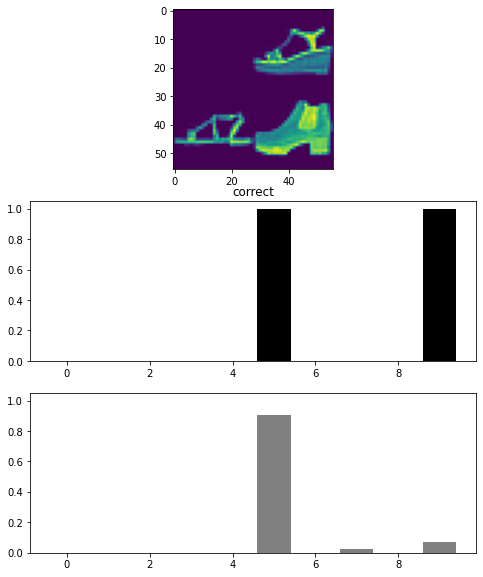


Sandal

Ankle_boot


In [90]:
final(2)

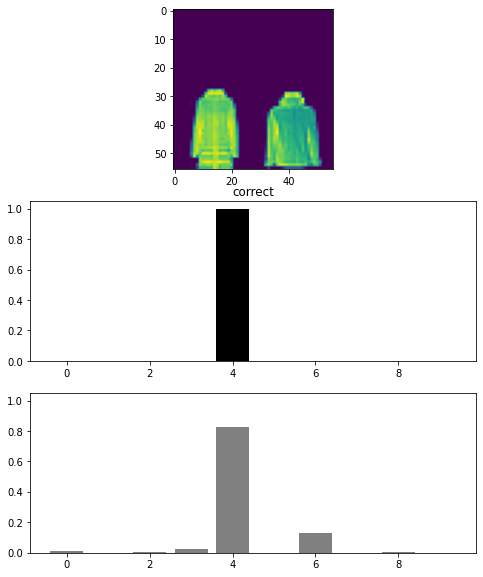


Coat


In [91]:
final(1227)

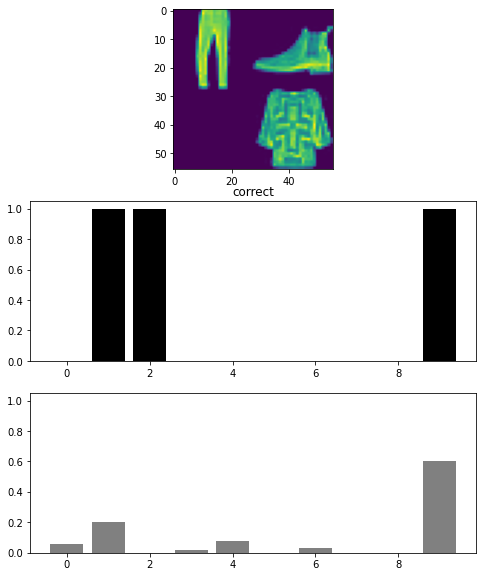


Trouser

Pullover

Ankle_boot


In [92]:
final(620)

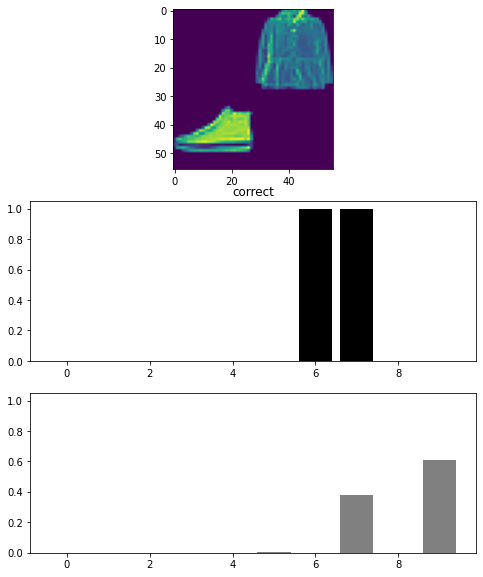


Shirt

Sneaker


In [96]:
final(222)

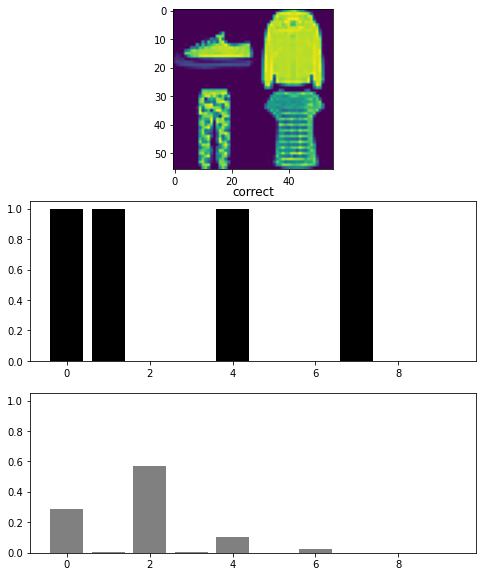


T-shirt/top

Trouser

Coat

Sneaker


In [98]:
# 정말 안맞는걸 볼 수 있다...
final(6)

    결과를 다시 보고 있는데 옷의 개수가 많아질 수록 예측을 제대로 못하는 것 같다....
    옷의 종류가 하나 이거나 객체가 하나 일때는 분류를 제대로 하는데
    2개 일때도 뭔가 비슷하게 유추하려 하고는 하지만 개수가 4개까지 늘어나버리면
    그냥 예측을 못한다고 봐야 할 것 같다...
    모델의 validation_accuracy가 약 40% 나왔는데 왠지 저 수치는
    객체가 1개일 때만 맞춘 것 같다..

In [99]:
# 배치를 활용해서 모델링을 해보자

In [120]:
# for 문을 활용해서 돌려보자
epochs = 15
batch_size = 16
new_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
for epoch in range(epochs) :
  for _ in range(0, len(train_images), batch_size) : 
    batch_x = []
    batch_y = []

    for _ in range(batch_size) :
      x, y = expand_4times(train_images, train_labels)
      batch_x.append(x)
      batch_y.append(y)
    
    batch_x = np.array(batch_x).reshape((-1,56,56,1))
    batch_y = np.array(batch_y).reshape((-1,10))

    new_model.train_on_batch(batch_x, batch_y)
  
  print(epoch+1, 'epochs Done!!' )
      # 돌릴 때 마다 이미지를 새로 만드는 느낌임.

1 epochs Done!!
2 epochs Done!!
3 epochs Done!!
4 epochs Done!!
5 epochs Done!!
6 epochs Done!!
7 epochs Done!!
8 epochs Done!!
9 epochs Done!!
10 epochs Done!!
11 epochs Done!!
12 epochs Done!!
13 epochs Done!!
14 epochs Done!!
15 epochs Done!!


In [102]:
res = new_model.predict(test_multi_images[4].reshape((-1,56,56,1)))
res.shape

(1, 10)

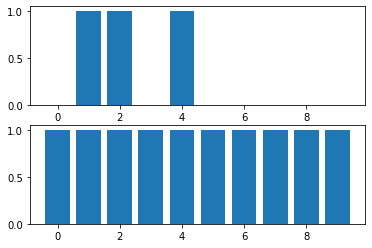

In [122]:
res = new_model.predict(test_multi_images[571].reshape((-1,56,56,1)))

plt.subplot(211)
plt.bar( np.arange(0,10), test_multi_labels[571])

plt.subplot(212)
plt.bar(np.arange(0,10), res[0])

plt.show()

In [111]:
test_multi_labels[3]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

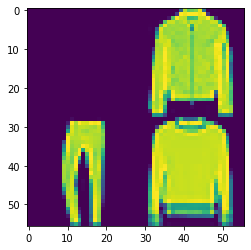

In [116]:
plt.imshow(test_multi_images[571].reshape((56,56)))

In [123]:
# 모델부터 다시 손보자...

In [124]:
from keras.layers import GlobalAvgPool2D

In [125]:
def model2() :
  input = Input((56,56,1))
  x = Conv2D(16, 2, padding='same',activation='relu')(input)
  x = MaxPool2D(2)(x)
  x = Dropout(0.3)(x)

  x = Conv2D(32, 2, padding='same',activation='relu')(x)
  x = MaxPool2D(2)(x)
  x = Dropout(0.3)(x)

  x = Conv2D(64, 2, padding='same',activation='relu')(x)
  x = MaxPool2D(2)(x)
  
  x = GlobalAvgPool2D()(x)
  x = Dense(10, activation='softmax')(x)
  return Model(input,x)

In [126]:
model2 = model2()

In [127]:
model2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 16)        80        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0   

In [ ]:
test_exp

In [128]:
model2.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [130]:
hist3 = model2.fit(train_expand_images.reshape((-1,56,56,1)), 
                   to_categorical(train_labels,10),
                   validation_data = (test_expand_images.reshape((-1,56,56,1)), to_categorical(test_labels, 10)),
                   epochs = 15,
                   verbose = 1
           )

Epoch 1/15
938/938 [==============================] - 4s 4ms/step - loss: 1.9134 - accuracy: 0.2973 - val_loss: 1.2124 - val_accuracy: 0.5798
Epoch 2/15
938/938 [==============================] - 4s 4ms/step - loss: 1.1797 - accuracy: 0.5820 - val_loss: 1.0010 - val_accuracy: 0.6530
Epoch 3/15
938/938 [==============================] - 4s 4ms/step - loss: 1.0068 - accuracy: 0.6408 - val_loss: 0.8926 - val_accuracy: 0.6888
Epoch 4/15
938/938 [==============================] - 4s 4ms/step - loss: 0.9157 - accuracy: 0.6739 - val_loss: 0.8451 - val_accuracy: 0.7060
Epoch 5/15
938/938 [==============================] - 4s 4ms/step - loss: 0.8614 - accuracy: 0.6872 - val_loss: 0.7961 - val_accuracy: 0.7216
Epoch 6/15
938/938 [==============================] - 4s 4ms/step - loss: 0.8163 - accuracy: 0.7043 - val_loss: 0.7877 - val_accuracy: 0.7130
Epoch 7/15
938/938 [==============================] - 4s 4ms/step - loss: 0.7895 - accuracy: 0.7155 - val_loss: 0.7384 - val_accuracy: 0.7316
Epoch 

In [131]:
def multi_model2(model) :
  model.trainable = False
  x = model.layers[-2].output
  x = Dense(10, activation = 'sigmoid')(x)
  return Model(model.input, x)

In [132]:
new_model2 = multi_model2(model2)
new_model2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 16)        80        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0   

In [133]:
new_model2.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])
hist4 = new_model2.fit(train_multi_images, train_multi_labels,
                       validation_data = (test_multi_images, test_multi_labels),
                       epochs = 15,
                       verbose = 1)

Epoch 1/15
938/938 [==============================] - 3s 3ms/step - loss: 6.7504 - accuracy: 0.0929 - val_loss: 4.4262 - val_accuracy: 0.1610
Epoch 2/15
938/938 [==============================] - 3s 3ms/step - loss: 4.4310 - accuracy: 0.1551 - val_loss: 4.1594 - val_accuracy: 0.2224
Epoch 3/15
938/938 [==============================] - 3s 3ms/step - loss: 4.2379 - accuracy: 0.2021 - val_loss: 4.0445 - val_accuracy: 0.2504
Epoch 4/15
938/938 [==============================] - 3s 3ms/step - loss: 4.0995 - accuracy: 0.2234 - val_loss: 3.9558 - val_accuracy: 0.2798
Epoch 5/15
938/938 [==============================] - 3s 3ms/step - loss: 4.0306 - accuracy: 0.2559 - val_loss: 3.8390 - val_accuracy: 0.3072
Epoch 6/15
938/938 [==============================] - 3s 3ms/step - loss: 3.9979 - accuracy: 0.2703 - val_loss: 3.8771 - val_accuracy: 0.3162
Epoch 7/15
938/938 [==============================] - 3s 3ms/step - loss: 3.9882 - accuracy: 0.2783 - val_loss: 3.9241 - val_accuracy: 0.3162
Epoch 

In [135]:
# for 문을 활용해서 돌려보자
epochs = 15
batch_size = 16
new_model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
for epoch in range(epochs) :
  for _ in range(0, len(train_images), batch_size) : 
    batch_x = []
    batch_y = []

    for _ in range(batch_size) :
      x, y = expand_4times(train_images, train_labels)
      batch_x.append(x)
      batch_y.append(y)
    
    batch_x = np.array(batch_x).reshape((-1,56,56,1))
    batch_y = np.array(batch_y).reshape((-1,10))

    new_model2.train_on_batch(batch_x, batch_y)
  
  print(epoch+1, 'epochs Done!!' )
      # 돌릴 때 마다 이미지를 새로 만드는 느낌임.

1 epochs Done!!
2 epochs Done!!
3 epochs Done!!
4 epochs Done!!
5 epochs Done!!
6 epochs Done!!
7 epochs Done!!
8 epochs Done!!
9 epochs Done!!
10 epochs Done!!
11 epochs Done!!
12 epochs Done!!
13 epochs Done!!
14 epochs Done!!
15 epochs Done!!


In [141]:
res = new_model2.predict(test_multi_images[3].reshape((-1,56,56,1)))

<BarContainer object of 10 artists>

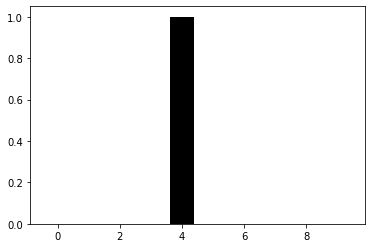

In [142]:
plt.bar(np.arange(0,10), test_multi_labels[3], color='black')

<BarContainer object of 10 artists>

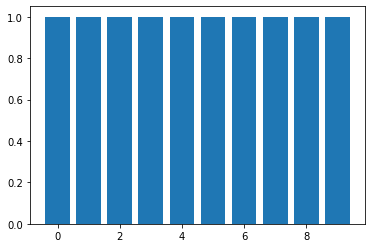

In [143]:
plt.bar(np.arange(0,10), res[0])

In [140]:
# 하...... 뭐가 문제일까...

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)